In [183]:
from utility_dnn import *
import utility_common as common

from IPython.display import clear_output
## add plotting option and load plotting parameter table
%matplotlib inline
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("savefig",dpi=300)

selection,nbjet = "mumu","==1"

# 0. Load Data 

In [162]:
tr = TrainingDataLoader(selection,nbjet)
tr.loadData()
trainset = MyDataset(tr.df_train.as_matrix(),tr.nvar)
trainloader = DataLoader(trainset, batch_size=1000,shuffle=True, num_workers=4)

# 1. Define DNN and Train DNN

In [178]:
#net = Net(tr.nvar,64,32,16,2)
net = torch.load(common.getBaseDirectory()+"data/networks/{}{}.pt".format(selection,tr.bname))

In [168]:
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.9)
for epoch in range(100):
    running_loss = 0.0
    for i, onebatch in enumerate(trainloader,0):
        # get the inputs
        inputs = Variable(onebatch["feature"])#.cuda()
        labels = Variable(onebatch["label"])#.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.data[0]    
    clear_output(wait=True)
    print('[%d] loss: %.5f' %(epoch + 1, running_loss))

print('Finished Training')
torch.save(net,common.getBaseDirectory()+"data/networks/{}{}.pt".format(selection,tr.bname))

[100] loss: 0.93483
Finished Training


# 3. Test Accuracy

In [184]:
plotter = DFPlotter(selection,nbjet)
dfList = plotter.getDataFrameList()
grader = DNNGrader(selection,nbjet)

In [185]:
dfList = grader.gradeDFList(dfList)

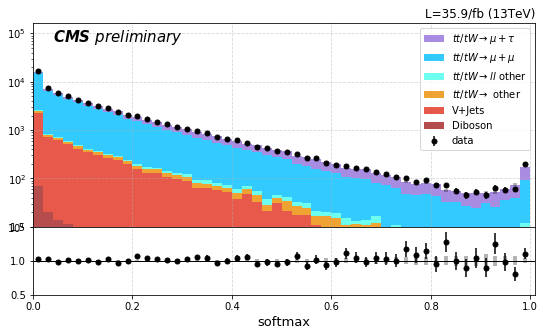

In [186]:
sk = ASingleKinematicPlot("softmax",0,1.01,0.02,dfList)
sk.settingPlot("softmax",plotter.labelList, plotter.colorList,logscale= True,figuresize = (9,5))
sk.makePlot(common.getBaseDirectory()+'plots/score/{}{}'.format(selection,grader.bname))

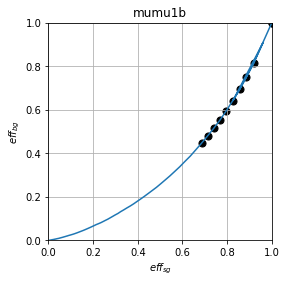

In [188]:
sg = dfList[5]
bg = pd.concat(dfList[1:5],ignore_index=True)

plt.figure(figsize=(4,4))   

effmcsg,effmcbg = np.ones(1),np.ones(1)

for thrd in np.arange(0.00,0.05,0.01):
    effmcsg = np.append(effmcsg, np.sum(sg.query('softmax>{}'.format(thrd)).eventWeight)/np.sum(sg.eventWeight) )
    effmcbg = np.append(effmcbg, np.sum(bg.query('softmax>{}'.format(thrd)).eventWeight)/np.sum(bg.eventWeight) )
for thrd in np.arange(0.001,1,0.01):
    effmcsg = np.append(effmcsg, np.sum(sg.query('softmax>{}'.format(thrd)).eventWeight)/np.sum(sg.eventWeight) )
    effmcbg = np.append(effmcbg, np.sum(bg.query('softmax>{}'.format(thrd)).eventWeight)/np.sum(bg.eventWeight) )
plt.plot(effmcsg,effmcbg)

effmcsg,effmcbg = np.ones(1),np.ones(1)
for thrd in np.arange(0.00,0.1,0.01):
    effmcsg = np.append(effmcsg, np.sum(sg.query('softmax>{}'.format(thrd)).eventWeight)/np.sum(sg.eventWeight) )
    effmcbg = np.append(effmcbg, np.sum(bg.query('softmax>{}'.format(thrd)).eventWeight)/np.sum(bg.eventWeight) )
plt.scatter(effmcsg,effmcbg,c='k',s=50)


plt.xlim(0,1)
plt.ylim(0,1)
plt.grid(True)
plt.xlabel(r"$eff_{sg}$")
plt.ylabel(r"$eff_{bg}$")
plt.title('{}{}'.format(selection,grader.bname))
plt.savefig(common.getBaseDirectory()+'plots/score/{}{}.pdf'.format(selection,grader.bname))

## check covariant matrix

In [9]:
data = dfList[-1]
corr = data.corr()
corr = corr['softmax']
for v in tr.var_list:
    print('{:20} : {:5.3}'.format(v,corr[v]))

dijet_eta            : 0.00353
dijet_mass           : -0.00192
dijet_phi            : 0.000654
dijet_pt             : 0.0238
dijet_pt_over_m      : -0.00124
dilepton_eta         : -0.0229
dilepton_mass        : -0.274
dilepton_phi         : -0.00356
dilepton_pt          : -0.289
dilepton_pt_over_m   : -0.0771
jet1_energy          : -0.00905
jet1_eta             : 0.00577
jet1_phi             : 0.0266
jet1_pt              : 0.00309
jet1_tag             : 0.0176
jet2_energy          : 0.00556
jet2_eta             : 0.00569
jet2_phi             : 0.000888
jet2_pt              : 0.0126
jet2_tag             : 0.0328
jet_delta_eta        : -0.00218
jet_delta_phi        : -0.0106
jet_delta_r          : -0.0123
lepton1_energy       : -0.226
lepton1_eta          : -0.0246
lepton1_reliso       : 0.0651
lepton1_phi          : 0.011
lepton1_pt           : -0.272
lepton2_energy       : -0.357
lepton2_eta          : 0.00192
lepton2_reliso       : 0.0641
lepton2_phi          : -0.00785
lepton2_pt    

## Plot All Variables with the Score Cut

In [ ]:
filterdf_list = grader.grgradeDFList(dfList,0.05)
plotter.labelList, plotter.colorList

sk = SelectionPlotter("lepton2_pt",0,150,5,filterdf_list)
sk.settingPlot("lepton2_pt [GeV]",plotter.labelList, plotter.colorList                   
                    logscale   = False,
                    isstacked  = True,
                    figuresize = (6,5.4))
sk.makePlot()

In [21]:
pp = pd.read_csv("plotter/plotparameters.csv")
for index, row in pp.iterrows():
    v,a,b,step,xl = row["var"],row["lower"],row["upper"],row["step"],row["xlabel"]
    plotter = SelectionPlotter(v,a,b,step,filterdf_list)
    plotter.settingPlot(xl,label_list,color_list,                    
                       logscale   = False,
                       isstacked  = True,
                       figuresize = (6,5.4))
    plotter.makePlot('../plot/{}/combined_{}/'.format(selection,slt))
    
    # print out process
    print("making plots: {0}/{1}".format(index,len(pp)))
    clear_output(wait=True)
    plt.close()
print('finish all making plots')

finish all making plots
